<a href="https://colab.research.google.com/github/AshwinNair1044/Data-Science/blob/master/Case_study_Ashwin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [86]:
df = pd.read_csv('/content/drive/My Drive/FODS group project/Jan_2019_ontime.csv')

# total null values in each column

In [87]:
df.isnull().sum()

DAY_OF_MONTH                  0
DAY_OF_WEEK                   0
OP_UNIQUE_CARRIER             0
OP_CARRIER_AIRLINE_ID         0
OP_CARRIER                    0
TAIL_NUM                   2543
OP_CARRIER_FL_NUM             0
ORIGIN_AIRPORT_ID             0
ORIGIN_AIRPORT_SEQ_ID         0
ORIGIN                        0
DEST_AIRPORT_ID               0
DEST_AIRPORT_SEQ_ID           0
DEST                          0
DEP_TIME                  16352
DEP_DEL15                 16355
DEP_TIME_BLK                  0
ARR_TIME                  17061
ARR_DEL15                 18022
CANCELLED                     0
DIVERTED                      0
DISTANCE                      0
Unnamed: 21              583985
dtype: int64

# total number of null values in dataset

In [88]:
df.isnull().sum().sum()

654318

# shape of dataset

In [89]:
df.shape

(583985, 22)

# the column 'Unnamed: 21' is useless as the entire column is full of null values

In [90]:
df.drop('Unnamed: 21',axis=1,inplace=True)

# creating two columns:
<h2> 
1) a date column in the form yyyy-mm-dd
<br>
2) a column indicating which day of week it is
</h2>

In [91]:
df['Date'] = pd.to_datetime('2019-01-' + df['DAY_OF_MONTH'].apply(str))
df['day_name'] = df['Date'].dt.day_name()
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Date,day_name
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,10397,1039707,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,2019-01-01,Tuesday
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,11193,1119302,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,2019-01-01,Tuesday
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,11193,1119302,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,2019-01-01,Tuesday
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,10397,1039707,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,2019-01-01,Tuesday
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,11778,1177801,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,2019-01-01,Tuesday


# visualising the number of carriers functioning in the airport

In [92]:
airlines = pd.DataFrame(df['OP_CARRIER'].value_counts().reset_index().values,columns=['OP_CARRIER','Number_of_planes'])
airlines.sort_values('OP_CARRIER',ascending = False)
airlines

,OP_CARRIER,Number_of_planes
0,WN,111312
1,AA,77017
2,DL,73836
3,OO,64926
4,UA,46915
5,YX,25755
6,MQ,25699
7,B6,24443
8,OH,23169
9,AS,20744


# plotting the share of flights

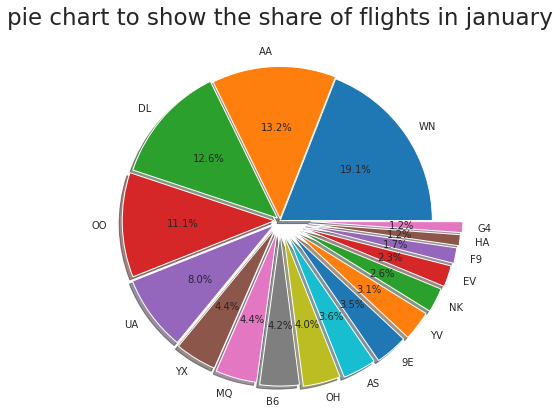

In [233]:
plt.figure(figsize=(7,7))
strip = np.linspace(0,0.2,17)
plt.pie(airlines['Number_of_planes'],labels=airlines['OP_CARRIER'],explode=strip,autopct='%0.01f%%',shadow=True)
plt.title('pie chart to show the share of flights in january',fontsize=23)
plt.show()

# clearly 4 airline carriers have more than 50% of all flights 

In [94]:
flights = df.groupby('day_name')['Date'].count().to_frame().reset_index()
flights.rename(columns={'Date':'number of flights'},inplace=True)
flights.sort_values('number of flights',ascending=False,inplace=True)

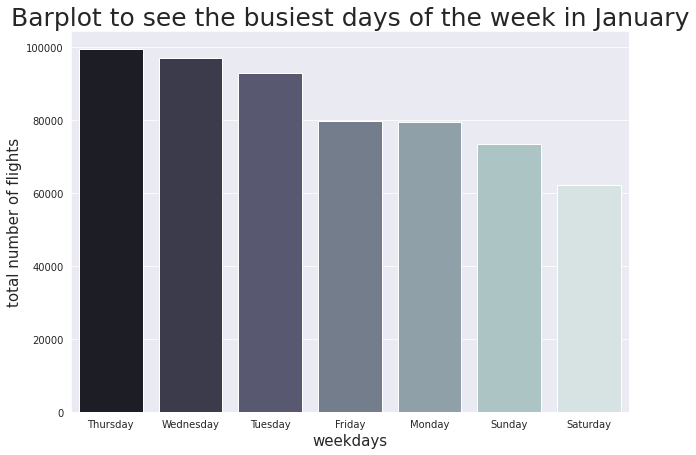

In [230]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,7))
sns.barplot(flights['day_name'],flights['number of flights'],label=flights['day_name'],palette='bone')
plt.ylabel('total number of flights',fontsize=15)
plt.xlabel('weekdays',fontsize=15)
plt.title('Barplot to see the busiest days of the week in January',fontsize=25)
plt.show()

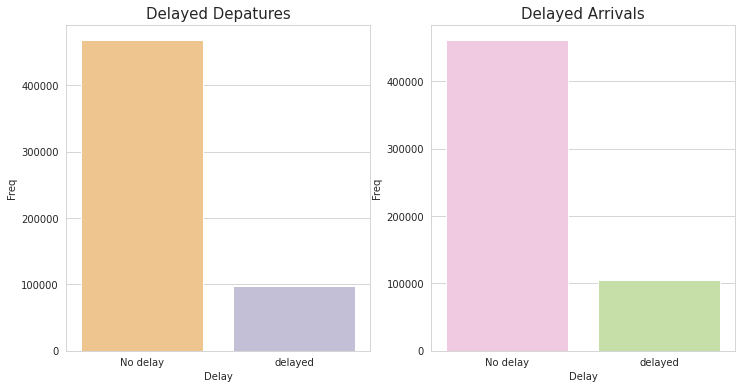

In [238]:
sns.set_style('whitegrid')
data = df.drop(['OP_UNIQUE_CARRIER','OP_CARRIER_AIRLINE_ID','OP_CARRIER','TAIL_NUM', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID'], axis=1)
data = data.set_index('OP_CARRIER_FL_NUM')
data.dropna(inplace=True)
columns = ['DAY_OF_WEEK','DAY_OF_MONTH','DEP_DEL15','ARR_DEL15','CANCELLED','DIVERTED']
for col in columns:
  data[col] = data[col].astype('category') 
data['DISTANCE_cat'] = pd.qcut(data['DISTANCE'], q=4)
changes = {0.0:"No delay",1.0:"delayed"}
dchanged = data[['DEP_DEL15','ARR_DEL15']].replace(changes)
f, (ax,ax1) = plt.subplots(1,2, figsize=(12,6))
dep = sns.countplot(dchanged['DEP_DEL15'], ax=ax,palette='PuOr')
dep.set_title('Delayed Depatures',fontsize=15)
dep.set_xlabel('Delay',fontsize=10)
dep.set_ylabel('Freq',fontsize=10)
arr = sns.countplot(dchanged['ARR_DEL15'], ax=ax1,palette='PiYG')
arr.set_title('Delayed Arrivals',fontsize=15)
arr.set_xlabel('Delay',fontsize=10)
arr.set_ylabel('Freq',fontsize=10)
plt.show()

# correlation between departure and arrival delay using heatmap

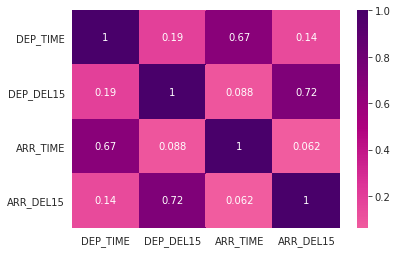

In [240]:
heat = df[['DEP_TIME','DEP_DEL15','ARR_TIME','ARR_DEL15']]
sns.heatmap(heat.corr(), xticklabels=heat.corr().columns, yticklabels=heat.corr().columns, cmap='RdPu', center=0, annot=True)
plt.show()

# we can see that when the flight is delayed at departure it is highly likely that it'll be delayed at arrival time, that is most flights ply on time 

# given a particular day what is the chance it will be delayed at arrival?

In [250]:
data = df[['day_name','Date','OP_CARRIER','ARR_DEL15']]
delayed_by_weekday = []
total_flights_on_each_day = []
prob = []
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
grouped = data.groupby(['day_name','ARR_DEL15'])
grouped2 = data.groupby('day_name')
for i in range(7):
  delayed_by_weekday.append(len(grouped.get_group((weekdays[i],1.0))))
  total_flights_on_each_day.append(len(grouped2.get_group(weekdays[i])))
  prob.append(round((delayed_by_weekday[i]/total_flights_on_each_day[i])*100,2))

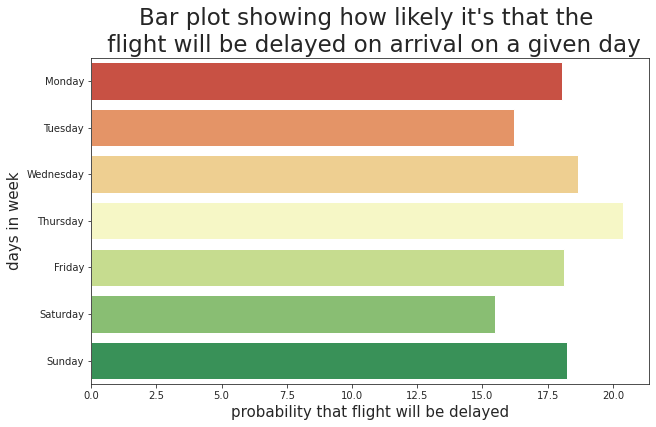

In [249]:
sns.set_style('ticks')
plt.figure(figsize=(10,6))
sns.barplot(prob,weekdays,palette='RdYlGn')
plt.xlabel('probability that flight will be delayed',fontsize=(15))
plt.ylabel('days in week',fontsize=(15))
plt.title("Bar plot showing how likely it's that the \n flight will be delayed on arrival on a given day",fontsize=(23))
plt.show()

# now we'll find how likely it is that given a particular carrier/airline will be delayed at arrival

In [215]:
carrier = data['OP_CARRIER'].unique()
total = len(data)
grouped = data.groupby(['OP_CARRIER','ARR_DEL15'])
grouped2 = data.groupby('OP_CARRIER')
total_flights_by_carrier = []
delayed_flights_by_carrier = []
prob = []
for i in range(len(carrier)):
  delayed_flights_by_carrier.append(len(grouped.get_group((carrier[i],1.0))))
  total_flights_by_carrier.append(len(grouped2.get_group(carrier[i])))
  prob.append(round((delayed_flights_by_carrier[i]/total_flights_by_carrier[i])*100,2))

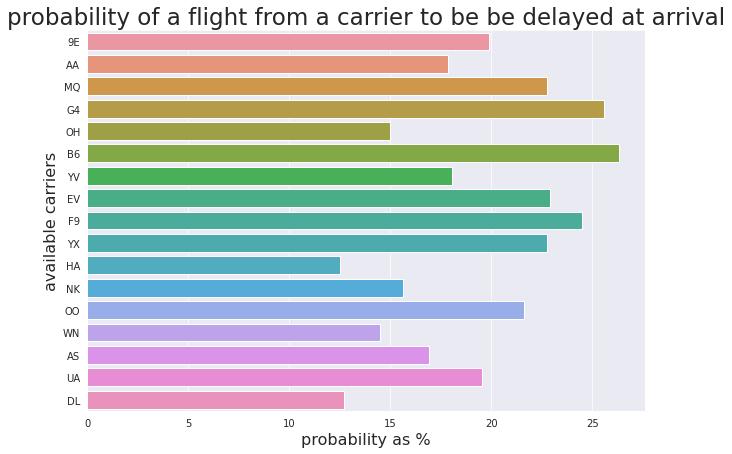

In [229]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,7))
sns.barplot(prob,carrier)
plt.title('probability of a flight from a carrier to be be delayed at arrival',fontsize=23)
plt.xlabel('probability as %',fontsize=16)
plt.ylabel('available carriers',fontsize=16)
plt.show()